In [1]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 30.0 MB/s 


In [1]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars
import pickle

import torch
import torchvision
from torchvision import transforms
#from torchmetrics import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cuda


In [3]:
class AutoEncodeDataset(Dataset):
    """"""

    def __init__(self, dataset_gt, dataset_blur):
        self.dataset_gt = dataset_gt
        self.dataset_blur = dataset_blur

    def __len__(self):
        return len(self.dataset_gt)

    def __getitem__(self, idx):
        x, _ = self.dataset_blur.__getitem__(idx)
        y, _ = self.dataset_gt.__getitem__(idx)
        return x, y

In [5]:
initial_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop(112),
    transforms.Normalize(0.5,0.5)])

blur_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop(112),
    transforms.GaussianBlur(9,4),
    transforms.Normalize(0.5,0.5)])

In [7]:
data_dir = './lfw_torch/'

train_dataset = AutoEncodeDataset(
    torchvision.datasets.LFWPeople(data_dir, split='train', download=True, transform=initial_transform),
    torchvision.datasets.LFWPeople(data_dir, split='train', download=True, transform=blur_transform)
)

test_dataset = AutoEncodeDataset(
    torchvision.datasets.LFWPeople(data_dir, split='test', download=True, transform=initial_transform),
    torchvision.datasets.LFWPeople(data_dir, split='test', download=True, transform=blur_transform)
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [8]:
batch_size = 8

N_val = int(len(train_dataset)*0.2)
train_dataset_red, val_dataset = random_split(train_dataset, 
                                 lengths=[len(train_dataset)-N_val, N_val], 
                                 generator=torch.Generator().manual_seed(42))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0,)
train_dataloader_red = DataLoader(train_dataset_red, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [9]:
def plotrescale(data):
    return np.dstack(data)*0.5 + 0.5

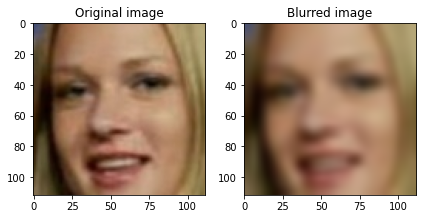

In [10]:
img = train_dataset[0][0].unsqueeze(0).to(device)
img2 = train_dataset[0][1].unsqueeze(0).to(device)
# Plot the reconstructed image
fig, axs = plt.subplots(1, 2, figsize=(6,3))
axs[0].imshow(plotrescale(img2.cpu().squeeze().numpy()))
axs[0].set_title('Original image')
axs[1].imshow(plotrescale(img.cpu().squeeze().numpy()))
axs[1].set_title('Blurred image')
plt.tight_layout()
plt.show()

In [15]:
class ConvAutoencoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        ## Encoder
        # N, 3, 112, 112
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 9), # N, 16, 104, 104
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 4, stride=2, padding=1), # N, 32, 51, 52
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1), # N, 32, 26
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, stride=2), # N, 32, 12
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        
        ## Decoder
        # N, 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 256, 4, stride=2), # N, 32, 10, 10
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), # N, 16, 28, 28
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), # N, 16, 56, 56
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 9),
            nn.Tanh()  
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
### Training cycle function
def train_epoch(model, device, dataloader, loss_fn, optimizer):
    model.train()
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    foo = tqdm(dataloader)
    for image_batch, label_batch in foo: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        label_batch = label_batch.to(device)
        # Encode-Decode data
        decoded_data = model(image_batch)
        ##
        #latent_img = model.encoder(image_batch)
        #latent_lab = model.encoder(label_batch)
        # Evaluate loss
        loss = loss_fn(decoded_data, label_batch) #+ loss_fn(latent_img, latent_lab)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        foo.set_description('Train batch loss: %f' % (loss.data))

### Testing cycle function
def test_epoch(model, device, dataloader, loss_fn):
    model.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        val_loss = []
        for image_batch, label_batch in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            label_batch = label_batch.to(device)
            # Encode-Decode data
            decoded_data = model(image_batch)
            ##
            #latent_img = model.encoder(image_batch)
            #latent_lab = model.encoder(label_batch)
            # Batch loss
            loss_batch = loss_fn(decoded_data, label_batch) #+ loss_fn(latent_img, latent_lab)
            # Append the loss
            val_loss.append(loss_batch.detach().cpu().numpy())
    return np.mean(val_loss)

### Trainer
def run_training(model, num_epochs, train_dataloader, val_dataloader, optim, loss_fn, device):
    model.to(device)
    val_loss_log = []
    for epoch in range(num_epochs):
        print('EPOCH %d/%d' % (epoch + 1, num_epochs))
        ### Training
        train_epoch(
            model=model,
            device=device, 
            dataloader=train_dataloader, 
            loss_fn=loss_fn, 
            optimizer=optim)
        ### Validation  (use the testing function)
        val_loss = test_epoch(
            model=model,
            device=device, 
            dataloader=val_dataloader, 
            loss_fn=loss_fn)
        # Print Validationloss
        print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))
        val_loss_log.append(val_loss)
        ### Plot progress
        # Get the output of a specific image (the test image at index 0 in this case)
        img = test_dataset[0][0].unsqueeze(0).to(device)
        lab = test_dataset[0][1].unsqueeze(0).to(device)
        model.eval()
        with torch.no_grad():
            rec_img  = model(img)
        # Plot the reconstructed image
        fig, axs = plt.subplots(1, 3, figsize=(9,3))
        axs[0].imshow(plotrescale(lab.cpu().squeeze().numpy()), cmap='gist_gray')
        axs[0].set_title('Original image')
        axs[1].imshow(plotrescale(img.cpu().squeeze().numpy()), cmap='gist_gray')
        axs[1].set_title('Blurred image')
        axs[2].imshow(plotrescale(rec_img.cpu().squeeze().numpy()), cmap='gist_gray')
        axs[2].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
        plt.tight_layout()
        plt.pause(0.1)
        plt.show()
        plt.close()

    #     # Save network parameters
    #     torch.save(model.state_dict(), 'CAE/state_dict'+str(epoch)+'.pth')

    # with open('CAE_validation_loss', 'wb') as fp:
    #     pickle.dump(val_loss_log, fp)

    return  val_loss_log

In [12]:
#with open('CAE_validation_loss', 'rb') as fp:
#  CAE_val_loss= pickle.load(fp)
#model.load_state_dict(torch.load('CAE/sdfdsfsd'))

In [16]:
### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
ConvAut = ConvAutoencoder()

### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer 
params_to_optimize = [
    {'params': ConvAut.encoder.parameters()},
    {'params': ConvAut.decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=5e-4, weight_decay=1e-5)

In [17]:
x1 = ConvAut.encoder[0](img.to('cpu'))
x2 = ConvAut.encoder[3](x1)
x3 = ConvAut.encoder[6](x2)
x4 = ConvAut.encoder[9](x3)
d1 = ConvAut.decoder[0](x4)
d2 = ConvAut.decoder[3](d1)
d3 = ConvAut.decoder[6](d2)
d4 = ConvAut.decoder[9](d3)
np.shape(d4)

torch.Size([1, 3, 112, 112])

In [18]:
CAE_loss = run_training(ConvAut, 30, train_dataloader, test_dataloader, optim, loss_fn, device) # 8 iter

  0%|          | 0/1191 [00:00<?, ?it/s]

EPOCH 1/30


Train batch loss: 0.084882:   4%|▎         | 43/1191 [00:16<07:18,  2.62it/s] 


KeyboardInterrupt: 

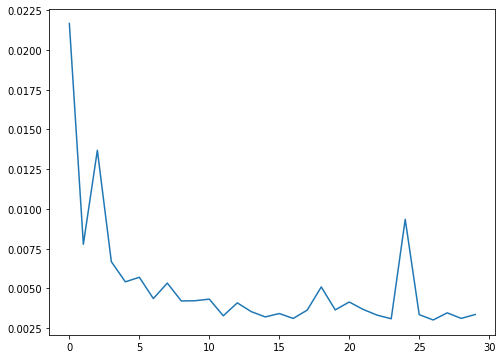

In [16]:
plt.figure(figsize=(8,6))
plt.plot(CAE_loss)
plt.show()

In [17]:
best_CAE = ConvAutoencoder()
best_CAE.load_state_dict(torch.load('CAE/state_dict17.pth'))

<All keys matched successfully>

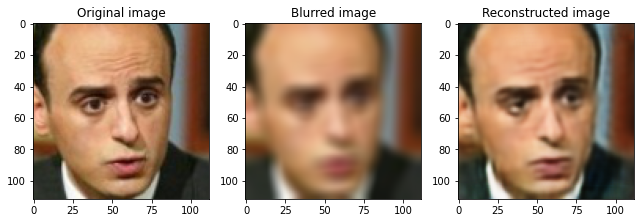

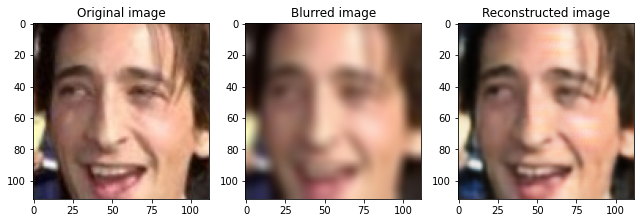

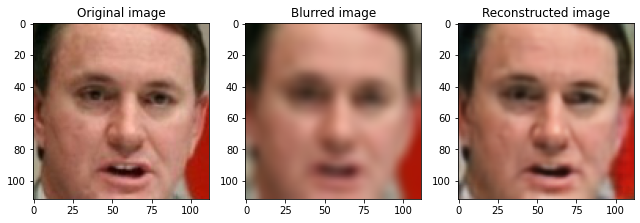

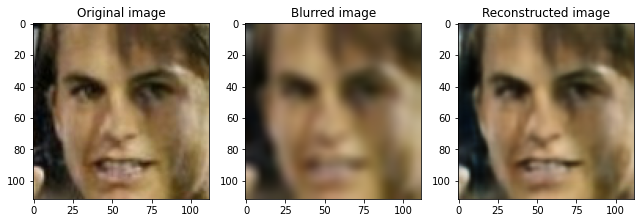

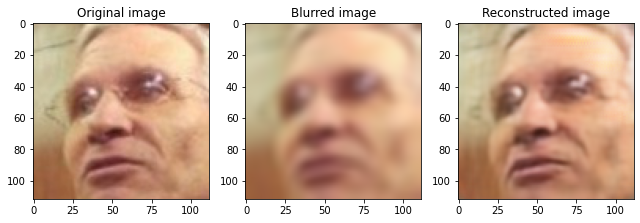

In [18]:
best_CAE.to(device)
for ii in [35, 45, 414, 172, 295]:
  img = test_dataset[ii][0].unsqueeze(0).to(device)
  lab = test_dataset[ii][1].unsqueeze(0).to(device)
  best_CAE.eval()
  with torch.no_grad():
      rec_img  = best_CAE(img)

  # Plot the reconstructed image
  fig, axs = plt.subplots(1, 3, figsize=(9,3))
  axs[0].imshow(plotrescale(lab.cpu().squeeze().numpy()))
  axs[0].set_title('Original image')
  axs[1].imshow(plotrescale(img.cpu().squeeze().numpy()))
  axs[1].set_title('Blurred image')
  axs[2].imshow(plotrescale(rec_img.cpu().squeeze().numpy()))
  axs[2].set_title('Reconstructed image')
  plt.tight_layout()
  plt.show()

## Implementing resblock

In [19]:
class RESConvAutoencoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        ## Encoder
        # N, 3, 112, 112
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 9), # N, 16, 104, 104
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 4, stride=2, padding=1), # N, 32, 51, 52
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1), # N, 32, 26
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, stride=2), # N, 32, 12
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        self.resblock1 = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.resblock2 = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.resblock3 = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        
        ## Decoder
        # N, 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 256, 4, stride=2), # N, 32, 10, 10
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), # N, 16, 28, 28
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), # N, 16, 56, 56
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 9),
            nn.Tanh()  
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = x + self.resblock1(x)
        x = x + self.resblock2(x)
        x = x + self.resblock3(x)
        x = self.decoder(x)
        return x
    
### Training cycle function
def train_epoch(model, device, dataloader, loss_fn, optimizer):
    model.train()
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    foo = tqdm(dataloader)
    for image_batch, label_batch in foo: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        label_batch = label_batch.to(device)
        # Encode-Decode data
        decoded_data = model(image_batch)
        ##
        #latent_img = model.encoder(image_batch)
        #latent_lab = model.encoder(label_batch)
        # Evaluate loss
        loss = loss_fn(decoded_data, label_batch) #+ loss_fn(latent_img, latent_lab)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        foo.set_description('Train batch loss: %f' % (loss.data))

### Testing cycle function
def test_epoch(model, device, dataloader, loss_fn):
    model.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        val_loss = []
        for image_batch, label_batch in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            label_batch = label_batch.to(device)
            # Encode-Decode data
            decoded_data = model(image_batch)
            ##
            #latent_img = model.encoder(image_batch)
            #latent_lab = model.encoder(label_batch)
            # Batch loss
            loss_batch = loss_fn(decoded_data, label_batch) #+ loss_fn(latent_img, latent_lab)
            # Append the loss
            val_loss.append(loss_batch.detach().cpu().numpy())
    return np.mean(val_loss)

### Trainer
def run_training(model, num_epochs, train_dataloader, val_dataloader, optim, loss_fn, device):
    model.to(device)
    val_loss_log = []
    for epoch in range(num_epochs):
        print('EPOCH %d/%d' % (epoch + 1, num_epochs))
        ### Training
        train_epoch(
            model=model,
            device=device, 
            dataloader=train_dataloader, 
            loss_fn=loss_fn, 
            optimizer=optim)
        ### Validation  (use the testing function)
        val_loss = test_epoch(
            model=model,
            device=device, 
            dataloader=val_dataloader, 
            loss_fn=loss_fn)
        # Print Validationloss
        print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))
        val_loss_log.append(val_loss)

        ### Plot progress
        # Get the output of a specific image (the test image at index 0 in this case)
        img = test_dataset[0][0].unsqueeze(0).to(device)
        lab = test_dataset[0][1].unsqueeze(0).to(device)
        model.eval()
        with torch.no_grad():
            rec_img  = model(img)
        # Plot the reconstructed image
        fig, axs = plt.subplots(1, 3, figsize=(9,3))
        axs[0].imshow(plotrescale(lab.cpu().squeeze().numpy()), cmap='gist_gray')
        axs[0].set_title('Original image')
        axs[1].imshow(plotrescale(img.cpu().squeeze().numpy()), cmap='gist_gray')
        axs[1].set_title('Blurred image')
        axs[2].imshow(plotrescale(rec_img.cpu().squeeze().numpy()), cmap='gist_gray')
        axs[2].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
        plt.tight_layout()
        plt.pause(0.1)
        plt.show()
        plt.close()

        # Save network parameters
        torch.save(model.state_dict(), 'RESCAE/state_dict'+str(epoch)+'.pth')

    with open('RESCAE_validation_loss', 'wb') as fp:
        pickle.dump(val_loss_log, fp)

    return  val_loss_log

In [20]:
### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
RESConvAut = RESConvAutoencoder()

### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer 
params_to_optimize = [
    {'params': RESConvAut.encoder.parameters()},
    {'params': RESConvAut.resblock1.parameters()},
    {'params': RESConvAut.resblock2.parameters()},
    {'params': RESConvAut.resblock3.parameters()},
    {'params': RESConvAut.decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=5e-4, weight_decay=1e-5)

EPOCH 1/30


Train batch loss: 0.024958: 100%|██████████| 1191/1191 [01:41<00:00, 11.73it/s]




	 VALIDATION - EPOCH 1/30 - loss: 0.014209




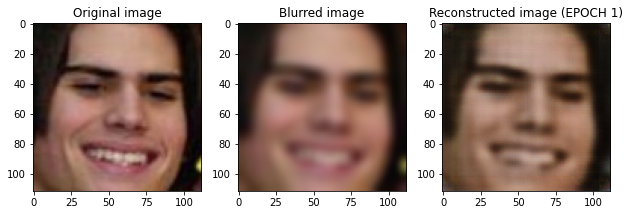

EPOCH 2/30


Train batch loss: 0.019738: 100%|██████████| 1191/1191 [01:44<00:00, 11.35it/s]




	 VALIDATION - EPOCH 2/30 - loss: 0.009381




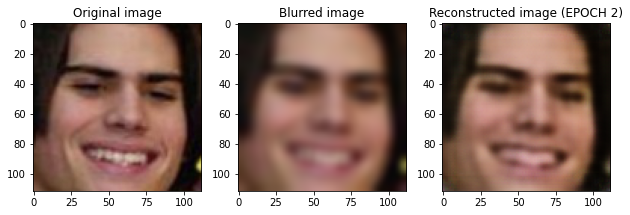

EPOCH 3/30


Train batch loss: 0.030175: 100%|██████████| 1191/1191 [01:43<00:00, 11.46it/s]




	 VALIDATION - EPOCH 3/30 - loss: 0.032319




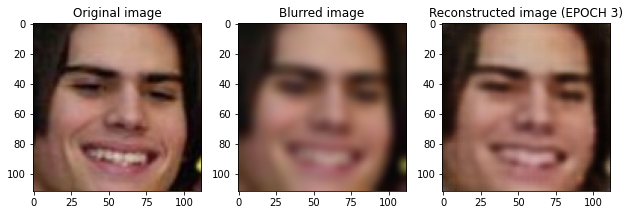

EPOCH 4/30


Train batch loss: 0.012007: 100%|██████████| 1191/1191 [01:43<00:00, 11.51it/s]




	 VALIDATION - EPOCH 4/30 - loss: 0.007452




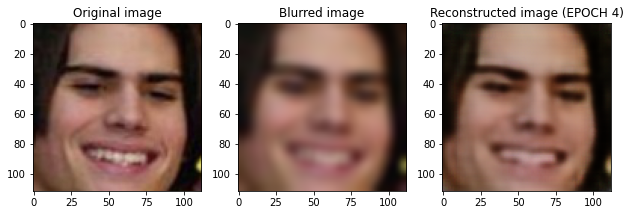

EPOCH 5/30


Train batch loss: 0.019898: 100%|██████████| 1191/1191 [01:44<00:00, 11.42it/s]




	 VALIDATION - EPOCH 5/30 - loss: 0.006344




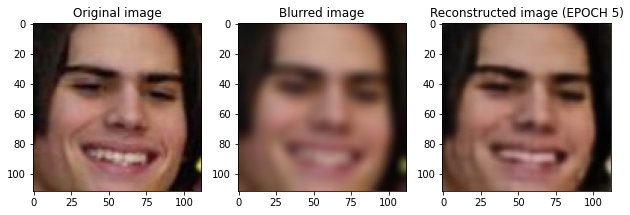

EPOCH 6/30


Train batch loss: 0.019295: 100%|██████████| 1191/1191 [01:45<00:00, 11.26it/s]




	 VALIDATION - EPOCH 6/30 - loss: 0.006170




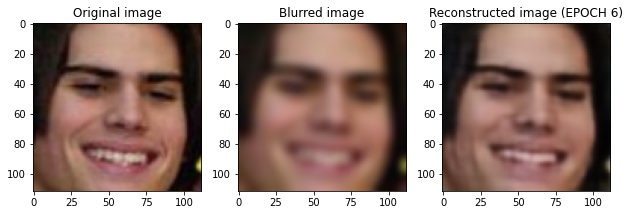

EPOCH 7/30


Train batch loss: 0.009807: 100%|██████████| 1191/1191 [01:46<00:00, 11.21it/s]




	 VALIDATION - EPOCH 7/30 - loss: 0.008732




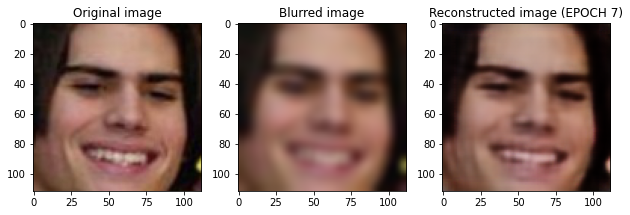

EPOCH 8/30


Train batch loss: 0.008146: 100%|██████████| 1191/1191 [01:46<00:00, 11.17it/s]




	 VALIDATION - EPOCH 8/30 - loss: 0.006082




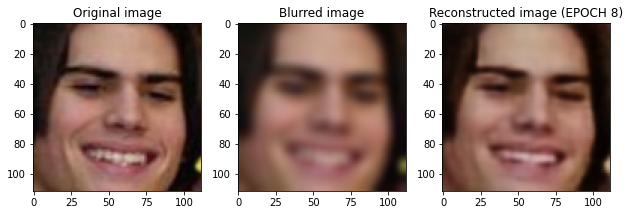

EPOCH 9/30


Train batch loss: 0.008119: 100%|██████████| 1191/1191 [01:47<00:00, 11.09it/s]




	 VALIDATION - EPOCH 9/30 - loss: 0.004221




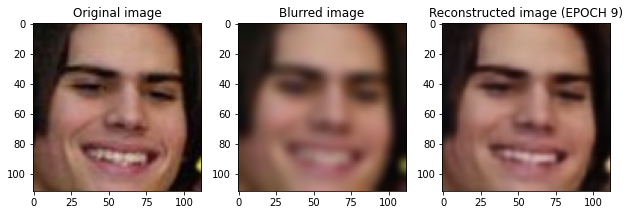

EPOCH 10/30


Train batch loss: 0.007383: 100%|██████████| 1191/1191 [01:49<00:00, 10.91it/s]




	 VALIDATION - EPOCH 10/30 - loss: 0.006149




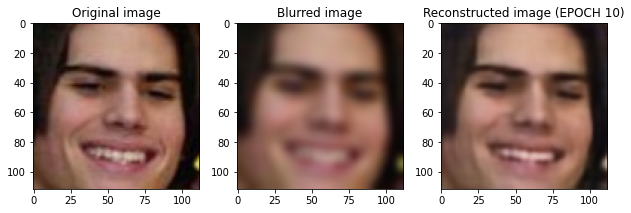

EPOCH 11/30


Train batch loss: 0.006324: 100%|██████████| 1191/1191 [01:49<00:00, 10.91it/s]




	 VALIDATION - EPOCH 11/30 - loss: 0.005579




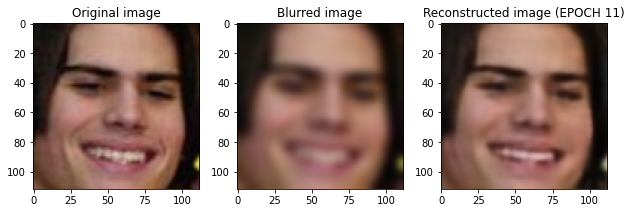

EPOCH 12/30


Train batch loss: 0.005418: 100%|██████████| 1191/1191 [01:49<00:00, 10.86it/s]




	 VALIDATION - EPOCH 12/30 - loss: 0.004006




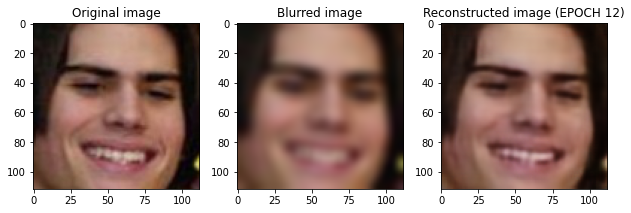

EPOCH 13/30


Train batch loss: 0.006278: 100%|██████████| 1191/1191 [01:52<00:00, 10.60it/s]




	 VALIDATION - EPOCH 13/30 - loss: 0.004630




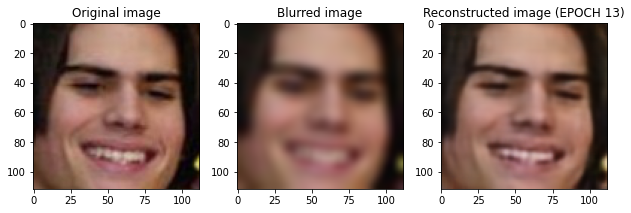

EPOCH 14/30


Train batch loss: 0.016436: 100%|██████████| 1191/1191 [01:54<00:00, 10.37it/s]




	 VALIDATION - EPOCH 14/30 - loss: 0.003682




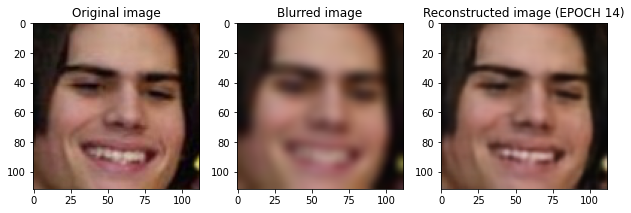

EPOCH 15/30


Train batch loss: 0.006670: 100%|██████████| 1191/1191 [02:00<00:00,  9.87it/s]




	 VALIDATION - EPOCH 15/30 - loss: 0.004876




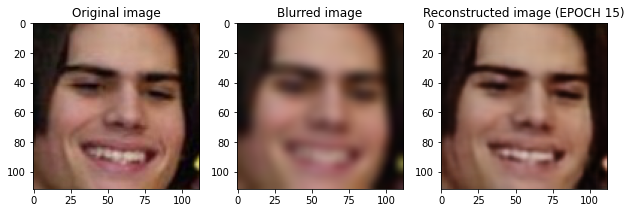

EPOCH 16/30


Train batch loss: 0.007073: 100%|██████████| 1191/1191 [01:54<00:00, 10.38it/s]




	 VALIDATION - EPOCH 16/30 - loss: 0.003800




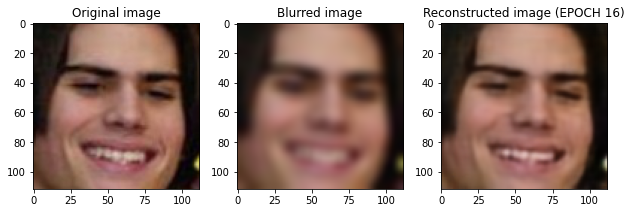

EPOCH 17/30


Train batch loss: 0.006579: 100%|██████████| 1191/1191 [01:54<00:00, 10.41it/s]




	 VALIDATION - EPOCH 17/30 - loss: 0.004509




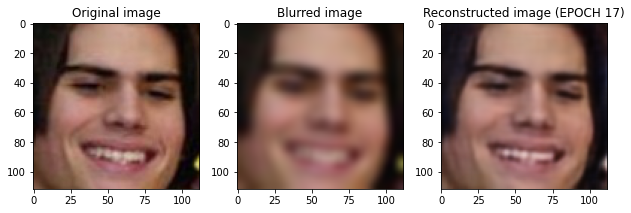

EPOCH 18/30


Train batch loss: 0.003876: 100%|██████████| 1191/1191 [01:55<00:00, 10.30it/s]




	 VALIDATION - EPOCH 18/30 - loss: 0.003167




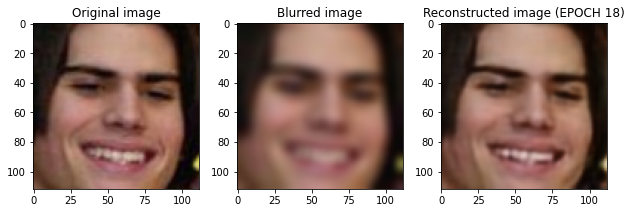

EPOCH 19/30


Train batch loss: 0.007533: 100%|██████████| 1191/1191 [01:57<00:00, 10.13it/s]




	 VALIDATION - EPOCH 19/30 - loss: 0.004157




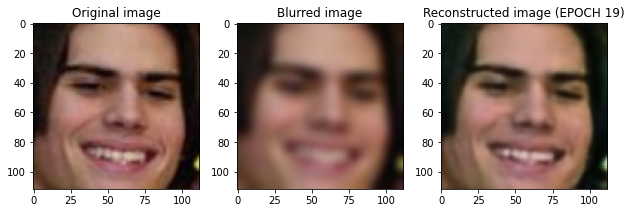

EPOCH 20/30


Train batch loss: 0.003732: 100%|██████████| 1191/1191 [02:05<00:00,  9.52it/s]




	 VALIDATION - EPOCH 20/30 - loss: 0.003558




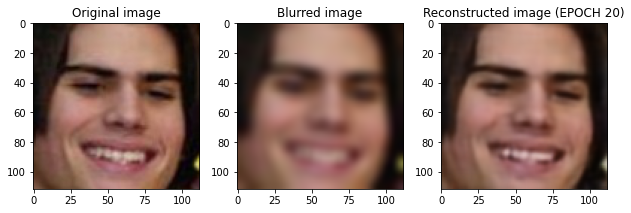

EPOCH 21/30


Train batch loss: 0.009158: 100%|██████████| 1191/1191 [02:06<00:00,  9.39it/s]




	 VALIDATION - EPOCH 21/30 - loss: 0.003362




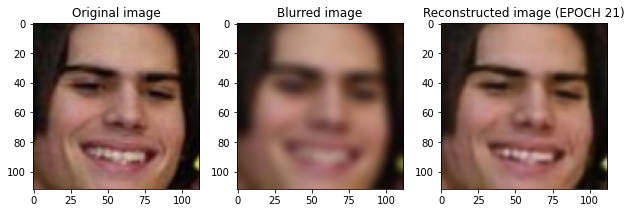

EPOCH 22/30


Train batch loss: 0.005319: 100%|██████████| 1191/1191 [02:06<00:00,  9.42it/s]




	 VALIDATION - EPOCH 22/30 - loss: 0.005343




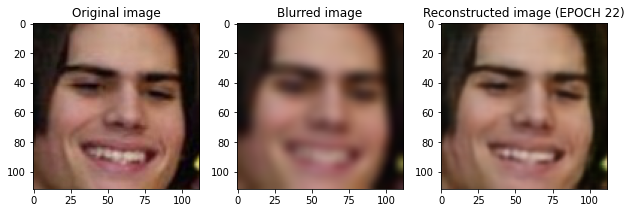

EPOCH 23/30


Train batch loss: 0.006330: 100%|██████████| 1191/1191 [02:10<00:00,  9.11it/s]




	 VALIDATION - EPOCH 23/30 - loss: 0.004353




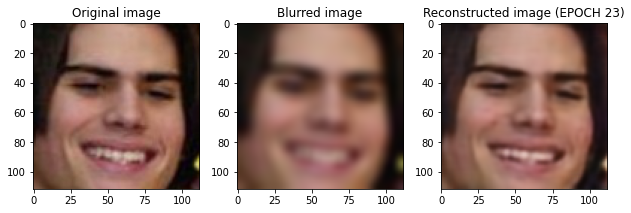

EPOCH 24/30


Train batch loss: 0.009946: 100%|██████████| 1191/1191 [02:11<00:00,  9.08it/s]




	 VALIDATION - EPOCH 24/30 - loss: 0.002976




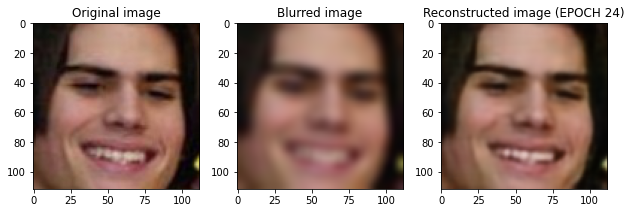

EPOCH 25/30


Train batch loss: 0.004774: 100%|██████████| 1191/1191 [02:09<00:00,  9.23it/s]




	 VALIDATION - EPOCH 25/30 - loss: 0.003318




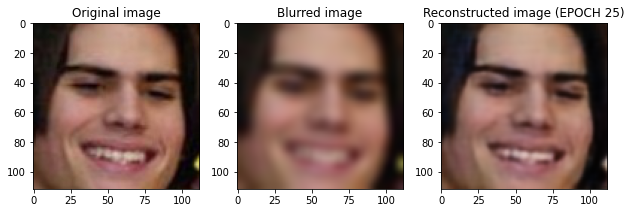

EPOCH 26/30


Train batch loss: 0.003964: 100%|██████████| 1191/1191 [02:09<00:00,  9.19it/s]




	 VALIDATION - EPOCH 26/30 - loss: 0.004652




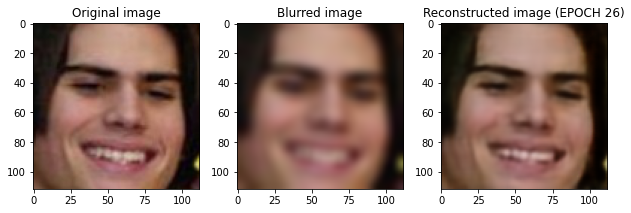

EPOCH 27/30


Train batch loss: 0.003166: 100%|██████████| 1191/1191 [02:09<00:00,  9.21it/s]




	 VALIDATION - EPOCH 27/30 - loss: 0.004148




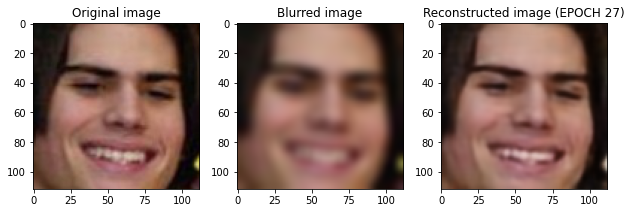

EPOCH 28/30


Train batch loss: 0.004539: 100%|██████████| 1191/1191 [02:09<00:00,  9.20it/s]




	 VALIDATION - EPOCH 28/30 - loss: 0.003311




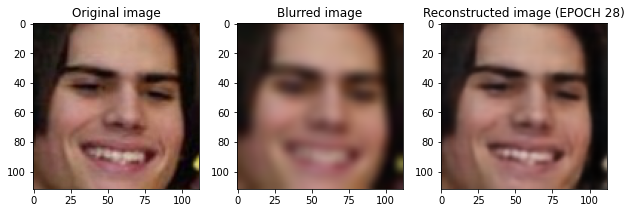

EPOCH 29/30


Train batch loss: 0.002845: 100%|██████████| 1191/1191 [02:09<00:00,  9.21it/s]




	 VALIDATION - EPOCH 29/30 - loss: 0.002718




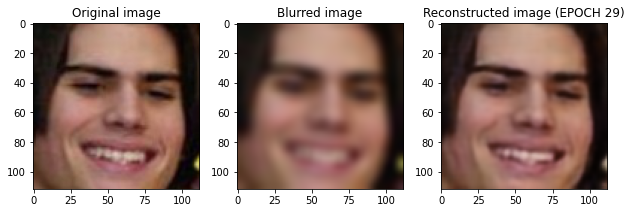

EPOCH 30/30


Train batch loss: 0.007585: 100%|██████████| 1191/1191 [02:11<00:00,  9.03it/s]




	 VALIDATION - EPOCH 30/30 - loss: 0.002939




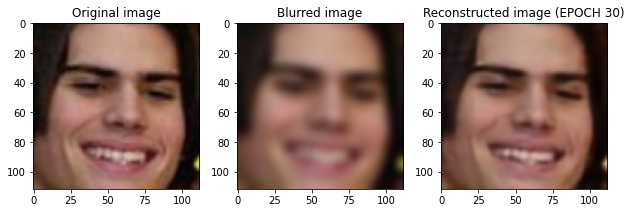

In [21]:
RESCAE_loss = run_training(RESConvAut, 30, train_dataloader, test_dataloader, optim, loss_fn, device) # 8 iter

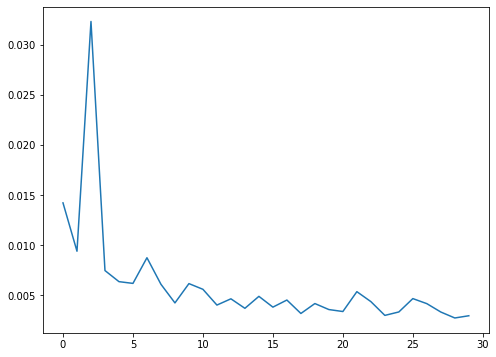

In [22]:
plt.figure(figsize=(8,6))
plt.plot(RESCAE_loss)
plt.show()

In [23]:
best_RESCAE = RESConvAutoencoder()
best_RESCAE.load_state_dict(torch.load('RESCAE/state_dict28.pth'))

<All keys matched successfully>

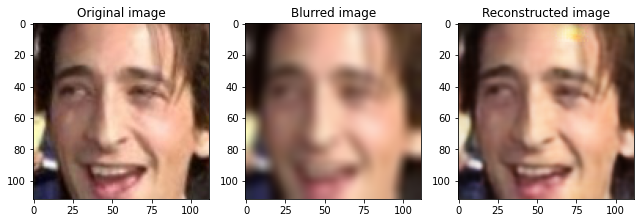

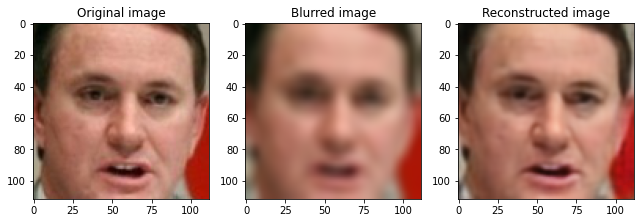

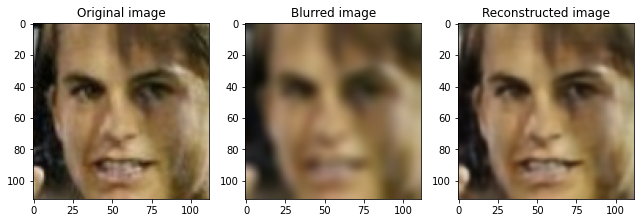

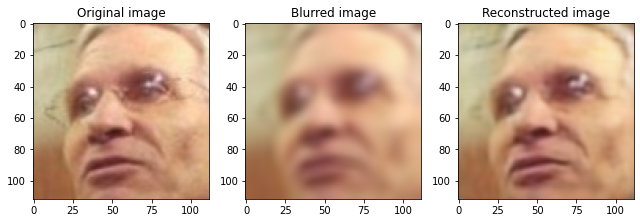

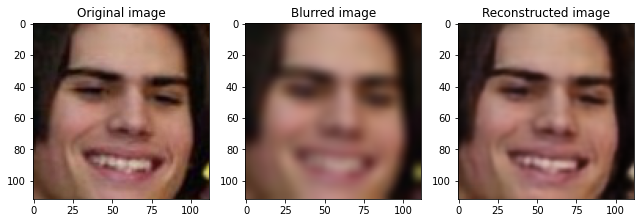

In [24]:
best_RESCAE.to(device)
for ii in [45, 414, 172, 295, 0]:
  img = test_dataset[ii][0].unsqueeze(0).to(device)
  lab = test_dataset[ii][1].unsqueeze(0).to(device)
  best_RESCAE.eval()
  with torch.no_grad():
      rec_img  = best_RESCAE(img)

  # Plot the reconstructed image
  fig, axs = plt.subplots(1, 3, figsize=(9,3))
  axs[0].imshow(plotrescale(lab.cpu().squeeze().numpy()))
  axs[0].set_title('Original image')
  axs[1].imshow(plotrescale(img.cpu().squeeze().numpy()))
  axs[1].set_title('Blurred image')
  axs[2].imshow(plotrescale(rec_img.cpu().squeeze().numpy()))
  axs[2].set_title('Reconstructed image')
  plt.tight_layout()
  plt.show()

In [25]:
rec_img.min()

tensor(-0.9845, device='cuda:0')

In [27]:
!zip -r /content/CAE_8.zip /content/CAE
!zip -r /content/RESCAE_8.zip /content/RESCAE

  adding: content/CAE/ (stored 0%)
  adding: content/CAE/state_dict3.pth (deflated 7%)
  adding: content/CAE/state_dict28.pth (deflated 11%)
  adding: content/CAE/state_dict2.pth (deflated 7%)
  adding: content/CAE/state_dict0.pth (deflated 7%)
  adding: content/CAE/state_dict10.pth (deflated 5%)
  adding: content/CAE/state_dict22.pth (deflated 10%)
  adding: content/CAE/state_dict17.pth (deflated 9%)
  adding: content/CAE/state_dict26.pth (deflated 11%)
  adding: content/CAE/state_dict8.pth (deflated 5%)
  adding: content/CAE/state_dict20.pth (deflated 10%)
  adding: content/CAE/state_dict7.pth (deflated 6%)
  adding: content/CAE/state_dict29.pth (deflated 11%)
  adding: content/CAE/state_dict27.pth (deflated 11%)
  adding: content/CAE/state_dict24.pth (deflated 10%)
  adding: content/CAE/state_dict12.pth (deflated 7%)
  adding: content/CAE/state_dict23.pth (deflated 10%)
  adding: content/CAE/state_dict11.pth (deflated 6%)
  adding: content/CAE/state_dict9.pth (deflated 4%)
  adding: